In [32]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler


def combine_data():
    # Directory containing participant CSV files
    data_dir = 'downsampled_data'

    # Initialize an empty list to store dataframes
    all_data = []

    # Loop through each participant's file
    for filename in os.listdir(data_dir):
        if filename.endswith('.csv'):
            # Load the CSV file
            participant_data = pd.read_csv("downsampled_data/"+filename)
            
            # Append to the list
            all_data.append(participant_data)

    # Combine all data into a single DataFrame
    combined_data = pd.concat(all_data, ignore_index=True)
    return combined_data


In [33]:
# Check the combined data
# print(combined_data)
combined_data = combine_data()
#remove rows hwere lseep stage is N3 and Missing
combined_data = combined_data[combined_data['sleep_stage'] != 'N3']
print(combined_data['sleep_stage'].value_counts())

#drop window times
combined_data = combined_data.drop(columns=["window_start_time", "window_end_time"])

# Encode sleep stage labels
label_mapping = {
    'W': 0,
    'N1': 1,
    'N2': 2,
    # 'N3': 3,
    'R': 3
}
num_classes = len(label_mapping)
combined_data['sleep_stage'] = combined_data['sleep_stage'].map(label_mapping)


features = combined_data.drop(columns=['sleep_stage'])
scaled_features = features.drop(columns=['participant_id'])
print(features.shape)
print(features.columns)

scaler = StandardScaler()
# scaled without participant id
scaled_features[scaled_features.columns] = scaler.fit_transform(scaled_features[scaled_features.columns])
scaled_features['participant_id'] = features['participant_id'] # add p_id back
num_features = features.shape[1] # includes participant_id

# Combine scaled features and labels
data_processed = np.hstack((scaled_features, combined_data[['sleep_stage']].values))
# print(combined_data.columns)
print(data_processed.shape)
print(data_processed[0])

sleep_stage
N2         32976
W          16095
N1          7375
R           7028
Missing       35
Name: count, dtype: int64
(63509, 28)
Index(['participant_id', 'BVP_mean', 'BVP_std', 'BVP_min', 'BVP_max',
       'BVP_range', 'BVP_median', 'SDNN', 'median_nni', 'IBI_mean', 'x_std',
       'y_std', 'z_std', 'mag_mean', 'mag_std', 'mag_max', 'movement_density',
       'burst_count', 'EDA_mean', 'EDA_std', 'EDA_trend', 'TEMP_mean',
       'TEMP_std', 'TEMP_slope', 'HR_mean', 'HR_std', 'HR_range', 'HR_trend'],
      dtype='object')
(63509, 29)
[3.6255561137747305 2.030505344041344 -4.28521139577816 2.2662414587067676
 3.378236120266564 -0.20405843488637804 0.06570277882531811
 0.006278004727448049 0.10023726835761346 0.39739606799101485
 0.005120012842885849 0.5665684179796675 0.9192812673170628
 0.2827832970411164 0.5059961538123006 -0.5625919688145246
 -0.6623311394376153 -0.48087717846308453 -0.193663486556077
 0.0038825830640811785 -0.7849422458452809 -0.18258645560663203
 -0.2114489756

In [34]:
class_dis = combined_data['sleep_stage'].value_counts()
print(class_dis)

sleep_stage
2.0    32976
0.0    16095
1.0     7375
3.0     7028
Name: count, dtype: int64


In [35]:
from scipy.stats import mode
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        
        # Extract the labels for the sequence
        sequence_labels = data[i:i+sequence_length, -1]  # Labels: sleep stage)
        if np.isnan(sequence_labels).any(): # skip nan labels
            continue
        
        X.append(data[i:i+sequence_length, :-1])  # Features (except the last which is sleep_stage)
        
        
        # Calculate the mode label (most frequent label in the sequence)
        # mode_label = mode(sequence_labels).mode  # Use scipy.stats.mode
        y.append(data[i:i+sequence_length, -1][-1])
        # print(data[i:i+sequence_length, -1])
    # print(np.array(X).shape, np.array(y).shape)
    return np.array(X), np.array(y)

sequence_length = 10  # 10 epochs = 5 minutes
# X, y = create_sequences(data_processed, sequence_length)

In [36]:
def process_df(df):
    df = df.drop(columns=['participant_id'])
    df_features = df.drop(columns=['sleep_stage'])
    data_proc = np.hstack((df_features, df[['sleep_stage']].values))
    return data_proc

In [37]:
from sklearn.model_selection import train_test_split

p_ids = np.unique(combined_data["participant_id"].values)

# Split by participant ID
train_ids, test_ids = train_test_split(np.unique(p_ids), test_size=0.2, random_state=42)
train_ids, val_ids = train_test_split(train_ids, test_size=0.25, random_state=42)  # 60% train, 20% val, 20% test

# Create splits
train_data = combined_data[combined_data['participant_id'].isin(train_ids)]
val_data = combined_data[combined_data['participant_id'].isin(val_ids)]
test_data = combined_data[combined_data['participant_id'].isin(test_ids)]

data_processed_tr = process_df(train_data)
# print(data_processed_tr.shape)
data_processed_val = process_df(val_data)
# print(data_processed_val.shape)
data_processed_test = process_df(test_data)
# print(data_processed_test.shape)

# Create sequences for each split
X_train, y_train = create_sequences(data_processed_tr, sequence_length)
# print(X_train.shape, y_train.shape)
X_val, y_val = create_sequences(data_processed_val, sequence_length)
# print(X_val.shape, y_val.shape)
X_test, y_test = create_sequences(data_processed_test, sequence_length)
# print(X_test.shape, y_test.shape)


In [38]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
y_train_flat = y_train.ravel()
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_flat), y=y_train_flat)
class_weights = dict(enumerate(class_weights))

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

model = Sequential()
model.add(Input(shape=(sequence_length, num_features-1)))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
    ]
)

Epoch 1/100
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 54s 29ms/step - accuracy: 0.3985 - loss: 1.3507 - val_accuracy: 0.3305 - val_loss: 1.4105 - learning_rate: 1.0000e-04
Epoch 2/100
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 63s 49ms/step - accuracy: 0.3824 - loss: 1.2796 - val_accuracy: 0.2967 - val_loss: 1.4254 - learning_rate: 1.0000e-04
Epoch 3/100
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 43s 37ms/step - accuracy: 0.3687 - loss: 1.2611 - val_accuracy: 0.3054 - val_loss: 1.3920 - learning_rate: 1.0000e-04
Epoch 4/100
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.3933 - loss: 1.2395 - val_accuracy: 0.3324 - val_loss: 1.3596 - learning_rate: 1.0000e-04
Epoch 5/100
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 32s 28ms/step - accuracy: 0.3929 - loss: 1.2317 - val_accuracy: 0.3271 - val_loss: 1.4377 - learning_rate: 1.0000e-04
Epoch 6/100
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 32s 28ms/step - accuracy: 0.4087 - loss: 1.2137 - val_accuracy: 0.3451 - val_loss: 1.4137 - learning_rate: 1.0000e-04
Epoch 7/100
1156/1156 ━━━━━━━━━━━━

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    class_weight=class_weights,  # Use computed class weights
    callbacks=callbacks
)

Epoch 1/50
 75/602 ━━━━━━━━━━━━━━━━━━━━ 27s 53ms/step - accuracy: 0.2825 - loss: 1.5000

KeyboardInterrupt: 

## Model 2 (with more layers)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

# Define the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    class_weight=class_weights,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64
)

model.save("lstm_model.keras")

Epoch 1/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - accuracy: 0.2696 - loss: 1.5031 - val_accuracy: 0.3545 - val_loss: 1.4974
Epoch 2/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - accuracy: 0.2426 - loss: 1.4539 - val_accuracy: 0.2344 - val_loss: 1.4896
Epoch 3/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.2565 - loss: 1.4172 - val_accuracy: 0.2346 - val_loss: 1.5160
Epoch 4/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.2374 - loss: 1.4027 - val_accuracy: 0.2327 - val_loss: 1.5029
Epoch 5/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.2521 - loss: 1.3433 - val_accuracy: 0.1650 - val_loss: 1.6917
Epoch 6/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.2641 - loss: 1.3390 - val_accuracy: 0.2250 - val_loss: 1.4905
Epoch 7/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.2722 - loss: 1.3146 - val_accuracy: 0.2212 - val_loss: 1.5478
Epoch 8/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - accuracy: 0.2703 - loss: 1.3037 - 

# Model Evaluation

411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4322 - loss: 1.3012
Test Accuracy: 42.25%
411/411 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step
F1-score: 0.44555838390231417


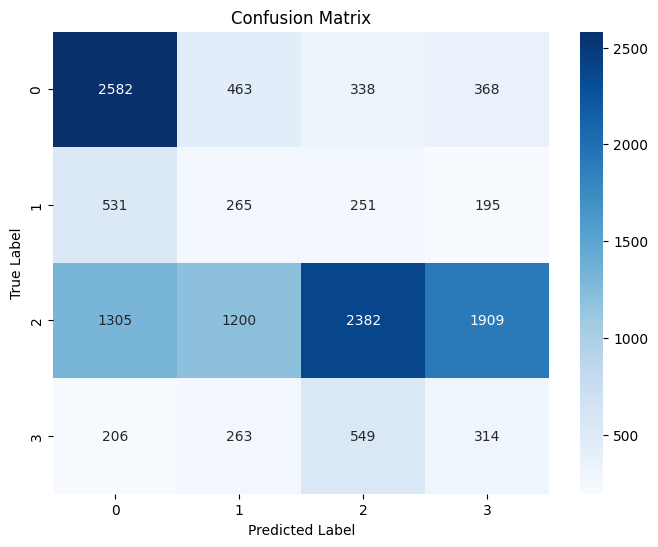

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Evaluate on test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Get model predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

from sklearn.metrics import f1_score
# Compute F1-score
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print("F1-score:", f1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(sequence_length, num_features), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X, y, epochs=10, batch_size=64)

model.save('full_model.keras')

C:\Users\Abelardo\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


NameError: name 'X' is not defined

      participant_id  window_start_time  window_end_time sleep_stage  \
0               S002             9174.0      9203.984375           W   
1               S002             9204.0      9233.984375           W   
2               S002             9234.0      9263.984375           W   
3               S002             9264.0      9293.984375           W   
4               S002             9294.0      9323.984375           W   
...              ...                ...              ...         ...   
65645           S102            30550.0     30579.984375           R   
65646           S102            30580.0     30609.984375           R   
65647           S102            30610.0     30639.984375           R   
65648           S102            30640.0     30669.984375           W   
65649           S102            30670.0     30699.984375           W   

       BVP_mean     BVP_std  BVP_min  BVP_max  BVP_range  BVP_median  ...  \
0      2.910635  156.689374 -1257.38   705.59    1962.97  

In [ ]:
combined_data = combined_data.drop(columns=["window_start_time", "window_end_time"])
combined_data["sleep_stage"] = combined_data["sleep_stage"].map(label_mapping)
X_c, y_c = create_sequences(combined_data, sequence_length)
print(X_c.shape)
print(y_c.shape)

InvalidIndexError: (slice(0, 10, None), slice(None, -1, None))